In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df = pd.read_csv("lego.population.csv", sep = ",", encoding = "latin1")

df

,Item_Number,Set_Name,Theme,Pieces,Price,Amazon_Price,Year,Ages,Pages,Minifigures,Packaging,Weight,Unique_Pieces,Availability,Size
0,41916,Extra Dots - Series 2,DOTS,109.0,$3.99,$3.44,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
1,41908,Extra Dots - Series 1,DOTS,109.0,$3.99,$3.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
2,11006,Creative Blue Bricks,Classic,52.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,28.0,Retail,Small
3,11007,Creative Green Bricks,Classic,60.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,36.0,Retail,Small
4,41901,Funky Animals Bracelet,DOTS,33.0,$4.99,$4.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,10.0,Retail,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,45678,SPIKE Prime Set,LEGO® Education,528.0,$329.95,NaN,2020,Ages_10+,NaN,2.0,NaN,NaN,108.0,NaN,Small
1300,71367,Mario's House & Yoshi,LEGO® Super Mario,205.0,$29.99,NaN,2020,Ages_6+,NaN,2.0,Box,NaN,114.0,Retail,Small
1301,71368,Toad's Treasure Hunt,LEGO® Super Mario,464.0,$69.99,NaN,2020,Ages_8+,NaN,4.0,Box,NaN,195.0,Retail,Small
1302,71369,Bowser's Castle Boss Battle,LEGO® Super Mario,1010.0,$99.99,NaN,2020,Ages_8+,NaN,NaN,Box,NaN,346.0,Retail,Small


In [3]:
# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages',  'Unique_Pieces']]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)

# det er dataset dere skal bruke!
df2

,Set_Name,Theme,Pieces,Price,Pages,Unique_Pieces
2,Creative Blue Bricks,Classic,52.0,4.99,37.0,28.0
3,Creative Green Bricks,Classic,60.0,4.99,37.0,36.0
11,Fire Truck,DUPLO,6.0,6.99,3.0,6.0
12,Tow Truck,DUPLO,7.0,6.99,3.0,7.0
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,52.0
...,...,...,...,...,...,...
1173,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,692.0
1174,Jurassic Park: T. rex Rampage,Jurassic World,3120.0,249.99,464.0,525.0
1175,Monkie Kid's Team Secret HQ,Monkie Kid,1105.0,169.99,556.0,622.0
1176,Grand Piano,Ideas,3662.0,349.99,564.0,345.0


In [4]:
#Definerer Temaer med spillassosiasjon
df2['HasGames'] = np.where(df2['Theme'].isin(['The Lego Movie 2', 'Friends', 'Marvel', 'Creator 3-in-1', 
                                              'Harry Potter', 'Batman', 'Creator Expert', 'DC', 
                                              'NINJAGO', 'Star Wars', 'City', 'Jurassic World', 
                                              'Minifigures']), 'yes', 'no')
df2.groupby(['HasGames']).size().reset_index(name='Count')


,HasGames,Count
0,no,367
1,yes,555


In [5]:
# Definerer lisensierte temaer
licensed_themes = [
    "Star Wars", "Marvel", "Disney", "The Lego Movie 2", "Minecraft",
    "Harry Potter", "Jurassic World", "Speed Champions", "Batman", "DC", "Trolls World Tour",
    "Overwatch", "LEGO Frozen 2", "Spider-Man", "Powerpuff Girls", "Minions",
    "Stranger things"
]

# Oppretter en ny kolonne 'Licensed' i datasettet
df2['Licensed'] = np.where(df2['Theme'].isin(licensed_themes), 'yes', 'no')

# Sjekker resultatet
df2[['Theme', 'Licensed']].head()


,Theme,Licensed
2,Classic,no
3,Classic,no
11,DUPLO,no
12,DUPLO,no
13,Friends,no


In [6]:
# Lager dummy-variabler for 'HasGames' og 'Licensed', og fjerner en kategori for å unngå multikollinearitet
df2 = pd.get_dummies(df2, columns=['HasGames', 'Licensed'], drop_first=False)

if 'HasGames_no' in df2.columns:
    df2 = df2.drop(columns=['HasGames_no'])

if 'Licensed_no' in df2.columns:
    df2 = df2.drop(columns=['Licensed_no'])

# Sjekker at kun de ønskede dummy-variablene er igjen
print(df2.columns)


Index(['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Unique_Pieces',
       'HasGames_yes', 'Licensed_yes'],
      dtype='object')


In [7]:
# Legger til interaksjonsvariabel
df2['HasGames_Licensed'] = df2['HasGames_yes'] * df2['Licensed_yes']

X = df2[['Pieces', 'HasGames_yes', 'Unique_Pieces', 'Pages', 'Licensed_yes', 'HasGames_Licensed']]
y = df2['Price']

# Konverterer boolske kolonner til float
X['HasGames_yes'] = X['HasGames_yes'].astype(float)
X['Licensed_yes'] = X['Licensed_yes'].astype(float)
X['HasGames_Licensed'] = X['HasGames_Licensed'].astype(float)

# Legger til konstantleddet i modellen
X = sm.add_constant(X)

# Kjører regresjonsanalysen
model = sm.OLS(y, X).fit()

# Viser oppsummering av regresjonsresultater
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     925.9
Date:                Sun, 17 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:55:05   Log-Likelihood:                -4149.4
No. Observations:                 922   AIC:                             8313.
Df Residuals:                     915   BIC:                             8347.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.8737      1.64

/tmp/ipykernel_455/2686860798.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HasGames_yes'] = X['HasGames_yes'].astype(float)
/tmp/ipykernel_455/2686860798.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Licensed_yes'] = X['Licensed_yes'].astype(float)
/tmp/ipykernel_455/2686860798.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

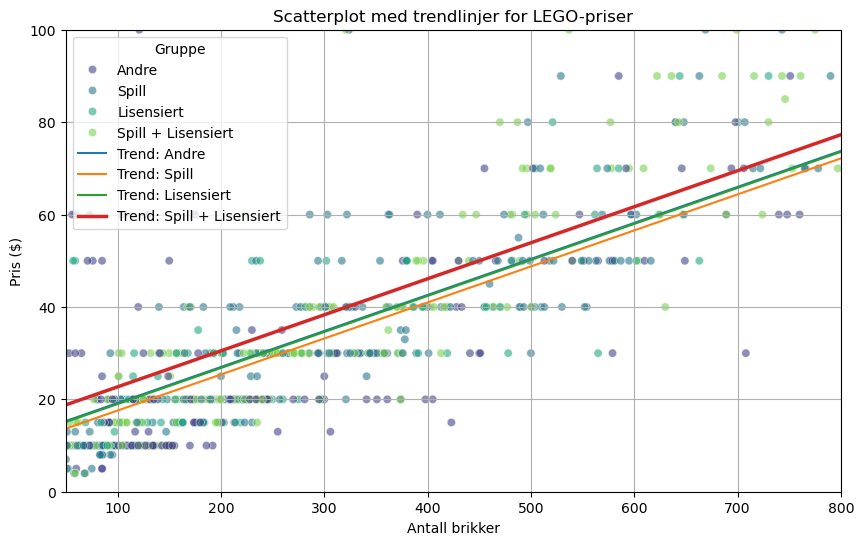

In [19]:
# Denne koden er generert med hjelp fra ChatGPT 4o

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filtrer data for å fokusere på relevante verdier
filtered_df = df2[(df2['Pieces'] >= 50) & (df2['Pieces'] <= 800)]

# Opprett en scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Pieces', y='Price', hue='Group', data=filtered_df, alpha=0.6, palette='viridis'
)

# Legg til trendlinjer basert på modellen
for group in filtered_df['Group'].unique():
    subset = filtered_df[filtered_df['Group'] == group]
    avg_unique_pieces = subset['Unique_Pieces'].mean()
    avg_pages = subset['Pages'].mean()
    
    # Simuler linje for Pieces
    pieces = np.linspace(50, 2000, 100)
    has_games = 1 if group in ['Spill', 'Spill + Lisensiert'] else 0
    licensed = 1 if group in ['Lisensiert', 'Spill + Lisensiert'] else 0
    interaction = has_games * licensed
    
    predicted_prices = (
        model.params['const'] +
        model.params['Pieces'] * pieces +
        model.params['HasGames_yes'] * has_games +
        model.params['Licensed_yes'] * licensed +
        model.params['HasGames_Licensed'] * interaction +
        model.params['Unique_Pieces'] * avg_unique_pieces +
        model.params['Pages'] * avg_pages
    )
    
    # Legg til trendlinje med tydelig farge og linjestil
    plt.plot(
        pieces, predicted_prices, label=f"Trend: {group}",
        linewidth=2.5 if group == "Spill + Lisensiert" else 1.5,
    )

# Juster aksene for zoom og klarhet
plt.xlim(50, 800)
plt.ylim(0, 100)

# Tilpass grafen
plt.title("Scatterplot med trendlinjer for LEGO-priser")
plt.xlabel("Antall brikker")
plt.ylabel("Pris ($)")
plt.legend(title="Gruppe", loc="upper left")
plt.grid(True)
plt.show()
